In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
item_categories = pd.read_csv('../data_cleaned/item_categories.csv')
items = pd.read_csv('../data_cleaned/items.csv')
shops = pd.read_csv('../data_cleaned/shops.csv')

In [3]:
merged = data_train.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')

In [4]:
dates = pd.to_datetime(merged['date'], format='%d.%m.%Y')


In [6]:
merged['month'] = dates.apply(lambda x:x.month)

In [7]:
grouped=merged.groupby(['shop_id','item_id','date_block_num']).agg({'item_price':'mean',
                                                                    'item_cnt_day':'sum',
                                                                    'item_category_name':'unique',
                                                                    'month':'unique'})#take some time

In [8]:
grouped=grouped.reset_index()

In [9]:
grouped['item_category_name']=grouped['item_category_name'].apply(lambda a:a[0])
grouped['month']=grouped['month'].apply(lambda a:a[0])

In [10]:
grouped=grouped.rename({'item_price':'avg_item_price','item_cnt_day':'item_cnt_month'}, axis='columns')

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5, 0, 'lag')

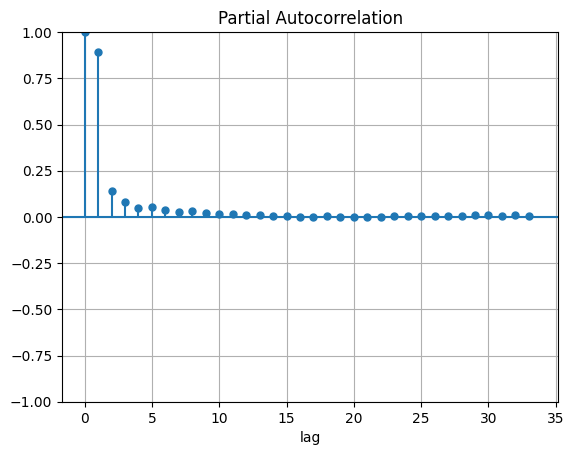

In [12]:
plot_pacf(grouped['avg_item_price'],lags=33)
plt.grid(visible=True)
plt.xlabel('lag')
#items price have strong relationship with first four lags

Text(0.5, 0, 'lag')

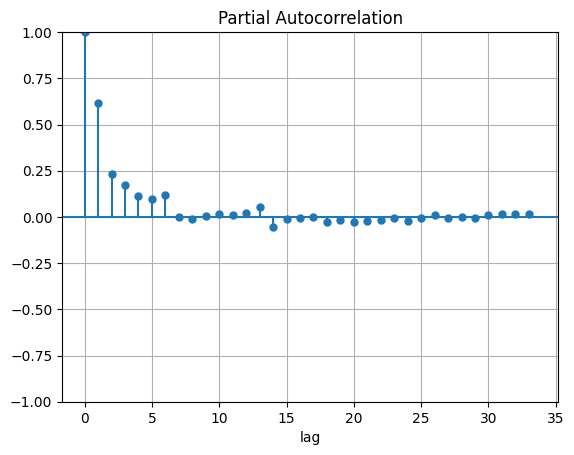

In [13]:
plot_pacf(grouped['item_cnt_month'],lags=33)
plt.grid(visible=True)
plt.xlabel('lag')
#items sales have strong relationship with ;lags 1-6 and 12-14 

In [14]:

def create_lags(data,item_lags=None,price_lags=None):
    lagged_items = data[['date_block_num','item_cnt_month','shop_id','item_id']].copy()
    for lag in item_lags:
        lagged_items['date_block_num']+=lag#previous month becomes present
        data=data.merge(lagged_items, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_items['date_block_num']-=lag

    lagged_prices = data[['date_block_num','avg_item_price','shop_id','item_id']].copy()
    for lag in price_lags:
        lagged_prices['date_block_num']+=lag#previous month becomes present
        data=data.merge(lagged_prices, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_prices['date_block_num']-=lag

        
    return data

In [15]:
item_lags=list([*range(1,7),12,13,14,24])
price_lags=list([*range(1,7),12,24])
lagged = create_lags(grouped,item_lags=item_lags,price_lags=price_lags)

Text(0.5, 1.0, 'Number of shop_item pairs from current month unseen on i-th lag')

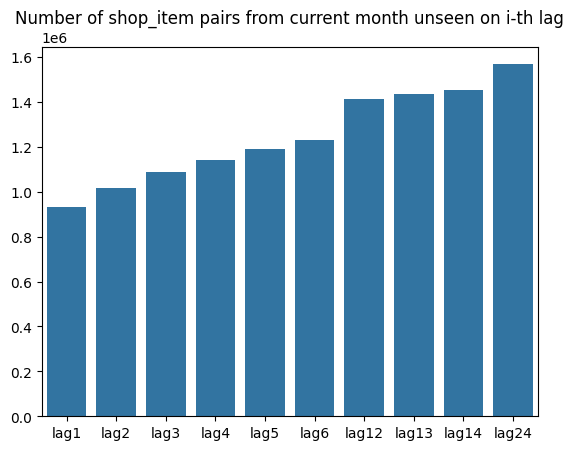

In [17]:
cntlags = lagged [[col for col in lagged.columns if 'item_cnt_month_lag_' in col]].isna().sum()
sns.barplot(cntlags)
plt.xticks(labels=['lag'+str(item_lag) for item_lag in item_lags],ticks=cntlags.index);

plt.title('Number of shop_item pairs from current month unseen on i-th lag')

Text(0.5, 1.0, 'Correlation between sales lags')

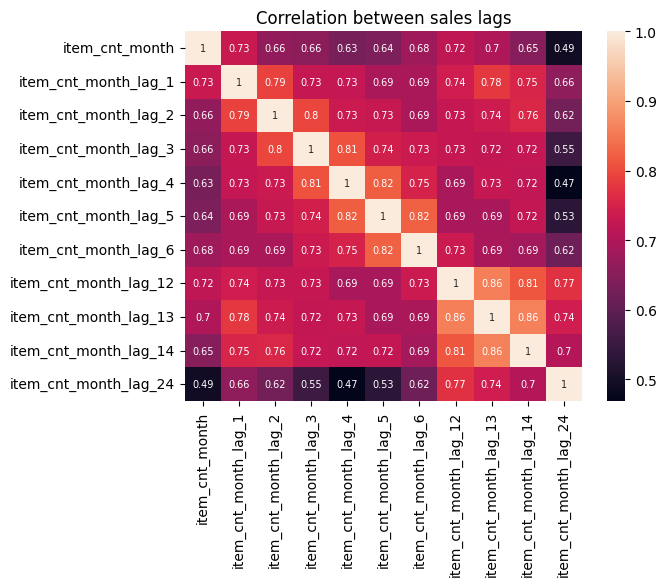

In [18]:
sns.heatmap(lagged[['item_cnt_month',*[f'item_cnt_month_lag_{i}' for i in item_lags]]].corr(),annot=True,annot_kws={'fontsize':7})
#In the potl below we can see, that the more month difference, the less corelation between sales
#Also we can see that monthes 12 and 13 have corellation stronger than previous monthes

plt.title('Correlation between sales lags')

Text(0.5, 1.0, 'Correlation between price lags')

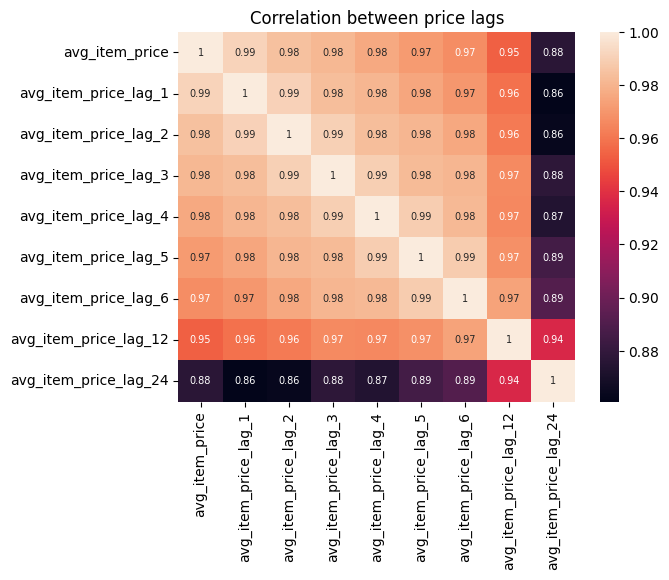

In [19]:
sns.heatmap(lagged[['avg_item_price',*[f'avg_item_price_lag_{i}' for i in price_lags]]].corr(),annot=True,annot_kws={'fontsize':7})
#In the potl below we can see, that the more month difference, the less corelation between prices
plt.title('Correlation between price lags')

Text(0.5, 1.0, 'Scatter plot of item_price - item_sales')

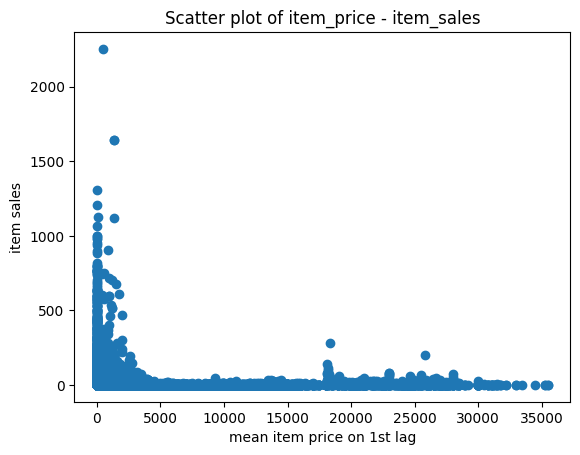

In [20]:

plt.scatter(lagged['avg_item_price_lag_1'],lagged['item_cnt_month'])
plt.xlabel('mean item price on 1st lag')
plt.ylabel('item sales')

plt.title('Scatter plot of item_price - item_sales')
#In the plot below we can see, that the lower the price the more sales.

Conclusion:
- Monthly sales are highly correlated with sales on previous monthes
- Average monthly price is very highly correlated with prices on previous monthes
- items sales have strong relationship with lags 1-6 and 13,14
- The more the price - the less sales)))